In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install shap
!pip install feature_engine

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.1/364.1 kB 6.9 MB/s eta 0:00:00


In [3]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=b6faea51579a8cd88d4c5e5acbbc302ef693c6df2f02c2e293d5df7cb4ff8bd4
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [4]:
!pip install -U imbalanced-learn scikit-learn

In [5]:
import os
import joblib
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats.mstats import winsorize
from scipy.stats import skew
from sklearn.utils import shuffle
from pandas.api.types import CategoricalDtype
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from feature_engine.selection import RecursiveFeatureAddition
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import BorderlineSMOTE
import shap
from sklearn.metrics import confusion_matrix
import seaborn as sns
import random

In [6]:
random.seed(42)

I am utilizing this code as guidance, https://github.com/inab-certh/Predicting-COVID-19-severity-through-interpretable-AI-analysis-of-plasma-proteomics/blob/main/Task%202.ipynb

Categorizing ages as follows:
- ages 0 to 40
- ages 41 to 60
- ages 61 to 80
- ages 81 and above

In [ ]:
def bin_age(data):
  age_bins = [0, 40, 60, 80, 100]
  age_labels = [0, 1, 2, 3]

  data['age'] = pd.cut(data['age'], bins=age_bins, labels=age_labels, right=True).astype(int)

  print("ISB Clinical:")
  print(data['age'].value_counts())

In [ ]:
def target_recode_scale(value):
    if value in [1, 2, 3, '1 or 2']:
        return 'mild'
    elif value in [4, 5]:
        return 'moderate'
    elif value in [6, 7]:
        return 'severe'

In [ ]:
def replace_unknown_with_mode(train_column, test_column):
    mode_value = train_column.mode()[0]
    return train_column.replace('Unknown', mode_value), test_column.replace('Unknown', mode_value)

In [ ]:
def get_data_type(data_path, file_type='excel'):
    if 'clinical' in data_path.lower():
        data = pd.read_excel(data_path, keep_default_na=False, na_values=['NA'])
    else:
        if file_type == 'csv':
            data = pd.read_csv(data_path, index_col=0)
        elif file_type == 'excel':
            data = pd.read_excel(data_path)
        elif file_type == 'txt':
            data = pd.read_csv(data_path, sep='\t', index_col=0)
        else:
            raise ValueError("Unsupported file type")
    print("Data loaded successfully.")

    if 'clinical' in data_path.lower():
        data_type = 'Clinical'
    elif 'metabolomics' in data_path.lower():
        data_type = 'Metabolomics'
    elif 'proteomics' in data_path.lower():
        data_type = 'Proteomics'
    else:
        raise ValueError("Unknown data type")

    print(data.columns)
    return data, data_type

In [ ]:
def preprocess_clinical(data, output_dir):
  data.drop('ethnicity', axis=1, inplace=True)
  data.set_index('subject_id', inplace=True)
  relevant_clinical_columns = ['who_severity', 'sex', 'age', 'cigarette_smoking', 'kidney_disease',
                            'chronic_hypertension', 'cancer', 'asthma', 'copd', 'coronary_artery_disease',
                            'respiratory_support']

  data = data[relevant_clinical_columns]
  print("ISB Clinical columns: ", data)

  data['respiratory_support'].replace({'None': 'None'}, inplace=True)
  print("These are the unique respiratory support values:", data['respiratory_support'].unique())
  clin_rows_with_na = data.isna().any(axis=1)

  print("Number of rows with at least one missing value:")
  print("ISB Clinical: ", clin_rows_with_na.sum())

  bin_age(data)
  data['who_severity'] = data['who_severity'].apply(target_recode_scale)
  print("ISB Clinical Severity Value Counts: ", data['who_severity'].value_counts())

  y = data['who_severity'].map({'mild': 0, 'moderate': 1, 'severe': 2})
  print("Target:", y.value_counts())

  X = data.drop(['who_severity'], axis = 1)

  if not os.path.exists(output_dir):
        os.makedirs(output_dir)
  joblib.dump(X, os.path.join(output_dir, 'X_clinical.pkl'))

  return X, y

In [ ]:
def preprocess_metabolomics(data, output_dir):
  data.set_index('subject_id', inplace=True)
  met_rows_with_na = data.isna().any(axis=1)

  print("Number of rows with at least one missing value:")
  print("ISB Metabolomics: ", met_rows_with_na.sum())
  X = data.drop(['Blood Draw', 'Healthy or INCOV', 'age', 'sex', 'BMI'], axis = 1)

  if not os.path.exists(output_dir):
        os.makedirs(output_dir)
  joblib.dump(X, os.path.join(output_dir, 'X_metabolomics.pkl'))

  return X

In [ ]:
def preprocess_proteomics(data, output_dir):
  data.set_index('subject_id', inplace=True)
  pro_rows_with_na = data.isna().any(axis=1)

  print("Number of rows with at least one missing value:")
  print("ISB Proteomics: ", pro_rows_with_na.sum())
  X = data.drop(['Blood Draw', 'Healthy or INCOV', 'age', 'sex', 'BMI'], axis = 1)

  if not os.path.exists(output_dir):
        os.makedirs(output_dir)
  joblib.dump(X, os.path.join(output_dir, 'X_proteomics.pkl'))

  return X

In [ ]:
def data_split(X, y, data_type):
  X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

  X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)
  print(f"{data_type} Train Target:", y_train.value_counts(normalize=True))
  return X_train, X_test, X_val, y_test, y_test, y_val

In [ ]:
def save_data_splits(X_train, X_test, X_val, y_train, y_test, y_val, output_dir, X_train_resampled=None, y_train_resampled=None):
    """
    Saves the train-test data splits to the specified directory using joblib.

    Args:
    - X_train (pd.DataFrame or np.ndarray): Training data features.
    - X_test (pd.DataFrame or np.ndarray): Testing data features.
    - y_train (pd.Series or np.ndarray): Training data labels.
    - y_test (pd.Series or np.ndarray): Testing data labels.
    - output_dir (str): Directory path where the data splits will be saved.

    Note:
    - If the output directory does not exist, it will be created.
    """

    assert X_train.shape[0] == y_train.shape[0], "Mismatch in training data and labels."
    assert X_test.shape[0] == y_test.shape[0], "Mismatch in testing data and labels."
    assert X_val.shape[0] == y_val.shape[0], "Mismatch in validation data and labels."

    print("Training set size:", X_train.shape, y_train.shape)
    print("Testing set size:", X_test.shape, y_test.shape)
    print("Validation set size:", X_val.shape, y_val.shape)

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    joblib.dump(X_train, os.path.join(output_dir, 'X_train.pkl'))
    joblib.dump(X_test, os.path.join(output_dir, 'X_test.pkl'))
    joblib.dump(X_val, os.path.join(output_dir, 'X_val.pkl'))
    joblib.dump(y_train, os.path.join(output_dir, 'y_train.pkl'))
    joblib.dump(y_test, os.path.join(output_dir, 'y_test.pkl'))
    joblib.dump(y_val, os.path.join(output_dir, 'y_val.pkl'))

    if X_train_resampled is not None and y_train_resampled is not None:
        joblib.dump(X_train_resampled, os.path.join(output_dir, 'X_train_resampled.pkl'))
        joblib.dump(y_train_resampled, os.path.join(output_dir, 'y_train_resampled.pkl'))

In [ ]:
def fill_missing(X_train, X_test, X_val):
  columns_to_fill = ['cancer', 'cigarette_smoking', 'asthma', 'copd', 'coronary_artery_disease']
  for column in columns_to_fill:
    if column in X_train.columns:
      X_train[column], X_test[column] = replace_unknown_with_mode(X_train[column], X_test[column])
      X_train[column], X_val[column] = replace_unknown_with_mode(X_train[column], X_val[column])
  return X_train, X_test, X_val

In [ ]:
def encode_ordinal_columns(X_train, X_test, X_val):
  cigarette_ordering = [['Never', 'Former', 'Current']]
  respiratory_support_ordering = [['None', 'Other', 'Nasal cannula', 'High flow nasal cannula (HFNC)']]
  encoder_cigarette = OrdinalEncoder(categories=cigarette_ordering)
  encoder_respiratory_support = OrdinalEncoder(categories=respiratory_support_ordering)
  columns_to_encode = ['cigarette_smoking', 'respiratory_support']

  for column in columns_to_encode:
      if column in X_train.columns:
        if column == 'cigarette_smoking':
            X_train['cigarette_smoking'] = encoder_cigarette.fit_transform(X_train[[column]])
            X_test['cigarette_smoking'] = encoder_cigarette.transform(X_test[[column]])
            X_val['cigarette_smoking'] = encoder_cigarette.transform(X_val[[column]])
        elif column == 'respiratory_support':
            X_train['respiratory_support'] = encoder_respiratory_support.fit_transform(X_train[[column]])
            X_test['respiratory_support'] = encoder_respiratory_support.transform(X_test[[column]])
            X_val['respiratory_support'] = encoder_respiratory_support.transform(X_val[[column]])
  return X_train, X_test, X_val

In [ ]:
def encode_binary_columns(X_train, X_test, X_val):
  binary_columns = ['sex', 'kidney_disease', 'chronic_hypertension', 'cancer', 'asthma', 'copd', 'coronary_artery_disease']
  binary_mapping = {'Male': 1, 'Yes': 1, 'Female': 0, 'No': 0}

  for column in binary_columns:
    if column in X_train.columns:
      X_train[column] = X_train[column].map(binary_mapping)
      X_val[column] = X_val[column].map(binary_mapping)
      X_test[column] = X_test[column].map(binary_mapping)
  return X_train, X_test, X_val

In [ ]:
def corr_matrix(X_train, output_dir):
    corr_matrix = X_train.corr().abs()

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, cmap='coolwarm', center=0, linewidths=1, annot=False, fmt=".2f")

    output_file = os.path.join(output_dir, 'correlation_matrix.png')

    plt.savefig(output_file)
    plt.show()

In [ ]:
def multicollinearity(X_test, output_dir):
    df_const = add_constant(X_test)

    vif_data = pd.DataFrame()
    vif_data["Variable"] = df_const.columns
    vif_data["VIF"] = [variance_inflation_factor(df_const.values, i) for i in range(df_const.shape[1])]

    print(vif_data)

    output_path = os.path.join(output_dir, "vif_data.csv")

    vif_data.to_csv(output_path, index=False)

In [ ]:
proteomics_scaling_selection = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('selector', RFE(estimator=LogisticRegression(), n_features_to_select=100))
])

metabolomics_scaling_selection = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('selector', RFE(estimator=LogisticRegression(), n_features_to_select=100))
])

In [ ]:
def omics_pipeline(X_train, X_val, X_test, y_train, data_type):
    if data_type == 'Clinical':
        print("Clinical data received. Skipping preprocessing.")
        return X_train, X_val, X_test

    elif data_type == 'Metabolomics':
        scaling_selection = metabolomics_scaling_selection
    elif data_type == 'Proteomics':
        scaling_selection = proteomics_scaling_selection
    else:
        raise ValueError(f"Data type {data_type} is not supported for this preprocessing.")

    X_train_preprocessed = scaling_selection.fit_transform(X_train, y_train)
    selected_features = X_train.columns[scaling_selection.named_steps['selector'].support_]

    X_val_preprocessed = scaling_selection.transform(X_val)
    X_test_preprocessed = scaling_selection.transform(X_test)

    X_train_preprocessed = pd.DataFrame(X_train_preprocessed, columns=selected_features, index=X_train.index)
    X_val_preprocessed = pd.DataFrame(X_val_preprocessed, columns=selected_features, index=X_val.index)
    X_test_preprocessed = pd.DataFrame(X_test_preprocessed, columns=selected_features, index=X_test.index)

    return X_train_preprocessed, X_val_preprocessed, X_test_preprocessed

In [ ]:
def pca_process(X_train_preprocessed, X_val_preprocessed, X_test_preprocessed, data_type):
  original_columns = X_train_preprocessed.columns.tolist()

  pca = PCA(.90)

  X_train_preprocessed = pd.DataFrame(pca.fit_transform(X_train_preprocessed), index=X_train_preprocessed.index)
  X_test_preprocessed = pd.DataFrame(pca.transform(X_test_preprocessed), index=X_test_preprocessed.index)
  X_val_preprocessed = pd.DataFrame(pca.transform(X_val_preprocessed), index=X_val_preprocessed.index)

  loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

  loading_matrix = pd.DataFrame(loadings, index=original_columns)
  loading_matrix

  load_trans = loading_matrix.T
  loading_pow = {}


  for i in load_trans.columns:
      magnitude = load_trans[i].pow(2).sum()
      loading_pow[i] = magnitude

  file_path_matrix = 'loading_matrix_' + data_type + '.xlsx'
  loading_matrix.to_excel(file_path_matrix)

  file_path_pow = 'loadingspow' + data_type + '.xlsx'
  pd.DataFrame.from_dict(loading_pow, orient='index').to_excel(file_path_pow)

  return X_train_preprocessed, X_val_preprocessed, X_test_preprocessed

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV
from numpy import mean
from sklearn.metrics import make_scorer, accuracy_score, roc_auc_score, f1_score, precision_score, recall_score
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

models = {
    'logistic_regression': LogisticRegression(),
    'decision_tree': DecisionTreeClassifier(),
    'rand_forest': RandomForestClassifier(),
    'extra_trees': ExtraTreesClassifier(),
    'mlp': MLPClassifier(),
    'svm': SVC(),
    'ada_boost': AdaBoostClassifier(),
    'xgb': xgb.XGBClassifier(),
    'gbm': GradientBoostingClassifier(),
    'qda': QuadraticDiscriminantAnalysis(),
}

log_params = {
    'logistic_regression__penalty': ['l1', 'l2'],
    'logistic_regression__C': [0.1, 1, 10],
    'logistic_regression__solver': ['liblinear', 'saga'],
    'logistic_regression__max_iter': [100, 200, 300, 400, 500, 600, 700, 800, 900],
    'logistic_regression__class_weight': [None, 'balanced']
}


dt_params = {
    'decision_tree__criterion': ['gini', 'entropy'],
    'decision_tree__max_depth': [None,1, 5, 10, 50, 100],
    'decision_tree__min_samples_split': [2, 5, 10],
    'decision_tree__min_samples_leaf': [1, 2, 4],
    'decision_tree__splitter':['best','random'],
    'decision_tree__class_weight': [None, 'balanced']
}

rf_params = {
    'rand_forest__n_estimators':[50,100,500,1000,2000],
    'rand_forest__criterion': ['gini', 'entropy'],
    'rand_forest__max_depth': [None, 5, 10, 20],
    'rand_forest__min_samples_split': [2, 5, 10],
    'rand_forest__min_samples_leaf': [1, 2, 4],
    'rand_forest__class_weight': [None, 'balanced']
}

et_params = {
    'extra_trees__n_estimators': [100, 200, 500, 1000, 2000],
    'extra_trees__criterion': ['gini', 'entropy'],
    'extra_trees__max_depth': [None, 5, 10],
    'extra_trees__min_samples_split': [2, 5, 10],
    'extra_trees__min_samples_leaf': [1, 2, 4],
    'extra_trees__class_weight': [None, 'balanced']
}

mlp_params = {
    'mlp__hidden_layer_sizes': [(100,), (100, 50), (50, 50), (50,50,50)],
    'mlp__activation': ['relu', 'tanh', 'logistic', 'identity'],
    'mlp__solver': ['adam', 'sgd', 'lbfgs'],
    'mlp__learning_rate':['constant','adaptive'],
    'mlp__alpha': [0.0001, 0.001, 0.01, 0.05],
    'mlp__max_iter': [100, 200, 300, 400, 500, 600, 700, 800, 900]
}

svm_params = {
    'svm__C':[0.1, 1, 2, 5, 10, 50, 100, 500],
    'svm__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'svm__gamma': ['scale', 'auto'],
    'svm__probability': [True],
    'svm__class_weight': [None, 'balanced'],
    'svm__max_iter': [100, 200, 300, 400, 500, 600, 700, 800, 900]
}

ada_params = {
    'ada_boost__n_estimators': [10, 20, 30, 50, 100, 200, 500, 1000],
    'ada_boost__learning_rate': [0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
}

xgb_params = {
    'xgb__n_estimators': [100, 200, 500],
    'xgb__learning_rate': [0.01, 0.03, 0.06, 0.1, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7],
    'xgb__max_depth': [3, 5, 7, 9, 11],
    'xgb__subsample': [0.8, 1.0],
    'xgb__colsample_bytree': [0.8, 1.0],
    'xgb__gamma': [0, 0.1, 0.2, 0.4, 0.8, 1.6, 3.2, 6.4, 12.8, 25.6, 51.2, 102.4, 200],
    'xgb__reg_alpha': [0, 0.1, 0.2, 0.4, 0.8, 1.6, 3.2, 6.4, 12.8, 25.6, 51.2, 102.4, 200],
    'xgb__reg_lambda': [0, 0.1, 0.2, 0.4, 0.8, 1.6, 3.2, 6.4, 12.8, 25.6, 51.2, 102.4, 200]
}

gbm_params = {
    'gbm__n_estimators': [50, 100, 200, 500, 1000, 2000],
    'gbm__learning_rate': [0.01, 0.1, 0.2, 0.3, 0.4],
    'gbm__max_depth': [3, 5, 7],
    'gbm__subsample': [0.8, 1.0],
    'gbm__max_features': ['sqrt', 'log2']
}

qda_params = {
    'qda__reg_param': [0, 0.5, 1]
}



params = {
    'logistic_regression': log_params,
    'decision_tree': dt_params,
    'rand_forest': rf_params,
    'extra_trees': et_params,
    'mlp': mlp_params,
    'svm': svm_params,
    'ada_boost': ada_params,
    'xgb': xgb_params,
    'gbm': gbm_params,
    'qda': qda_params,
}

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import BorderlineSMOTE, SVMSMOTE, RandomOverSampler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report
import time
import matplotlib.pyplot as plt


def model_search(models, params, over, under, X_train, y_train, X_test, y_test, X_val, y_val):
    print(f"Number of models: {len(models)}")
    training_times = []
    max_score = 0
    max_model = None
    max_model_params = None
    estimators_modelsearch = pd.DataFrame()
    models_est = []
    parameters = []
    lscore = []
    lroc = []
    lfscore_macro = []
    lfscore_weighted = []
    lprecision = []
    lrecall = []
    lrecall_severe = []
    lclass_report = []
    lcvscore = []
    lscore_val = []
    lroc_val = []
    lfscore_macro_val = []
    lfscore_weighted_val = []
    lprecision_val = []
    lrecall_val = []
    lrecall_severe_val = []
    lclass_report_val = []

    scoring = {
        'balanced_accuracy': 'balanced_accuracy',
        'accuracy': 'accuracy',
        'roc_auc': 'roc_auc_ovr',
        'precision': 'precision_macro',
        'recall_macro': make_scorer(recall_score, average='macro'),
        'f1_macro': make_scorer(f1_score, average='macro'),
        'f1_weighted': make_scorer(f1_score, average='weighted')
    }

    cv = StratifiedKFold(10)


    for i, j in models.items():
        start_time = time.time()

        try:
            pipeline = Pipeline([('over', over), ('under', under), (i, j)])

            rs = RandomizedSearchCV(
                estimator=pipeline,
                param_distributions=params[i],
                scoring=scoring,
                refit='roc_auc',
                cv=cv,
                n_iter=10,
                random_state=42,
                n_jobs=-1
            )

            rs.fit(X_train, y_train)

        except Exception as e:
            print(f"Error while fitting model {i}: {e}")
            continue



        y_pred = rs.predict(X_test)
        class_report = classification_report(y_test, y_pred)
        print(f"Classification Report for {i}:\n", class_report)

        y_pred_val = rs.predict(X_val)
        class_report_val = classification_report(y_val, y_pred_val)
        print(f"Validation Classification Report for {i}:\n", class_report_val)

        try:
            y_pred_proba = rs.predict_proba(X_test)
            lroc.append(roc_auc_score(y_test, y_pred_proba, multi_class='ovr'))
        except AttributeError:
            print(f"{i} does not support probability prediction. ROC AUC score cannot be computed.")
            lroc.append(None)

        try:
            y_pred_proba_val = rs.predict_proba(X_val)
            lroc_val.append(roc_auc_score(y_val, y_pred_proba_val, multi_class='ovr'))
        except AttributeError:
            print(f"{i} does not support probability prediction. ROC AUC score cannot be computed for validation set.")
            lroc_val.append(None)



        lscore.append(accuracy_score(y_test, y_pred))
        lscore_val.append(accuracy_score(y_val, y_pred_val))
        lcvscore.append(rs.best_score_)

        from sklearn.exceptions import UndefinedMetricWarning
        import warnings

        try:
            lprecision.append(precision_score(y_test, y_pred, average='macro', zero_division=0))
            lprecision_val.append(precision_score(y_val, y_pred_val, average='macro', zero_division=0))
        except UndefinedMetricWarning:
            print(f"Warning encountered for model {i}")
            print("Test predictions:", y_pred)
            print("Validation predictions:", y_pred_val)


        lrecall.append(recall_score(y_test, y_pred, average='macro'))
        lrecall_val.append(recall_score(y_val, y_pred_val, average='macro'))

        lfscore_macro.append(f1_score(y_test, y_pred, average='macro'))
        lfscore_macro_val.append(f1_score(y_val, y_pred_val, average='macro'))

        lfscore_weighted.append(f1_score(y_test, y_pred, average='weighted'))
        lfscore_weighted_val.append(f1_score(y_val, y_pred_val, average='weighted'))

        lrecall_severe.append(recall_score(y_test, y_pred, labels=[2], average='macro'))
        lrecall_severe_val.append(recall_score(y_val, y_pred_val, labels=[2], average='macro'))

        lclass_report.append(class_report)
        lclass_report_val.append(class_report_val)

        if lscore[-1] > max_score:
            max_score = lscore[-1]
            max_model = rs.best_estimator_
            max_model_params = rs.best_params_

        models_est.append(i)
        parameters.append(rs.best_params_)

    estimators_modelsearch['Models'] = models_est
    estimators_modelsearch['Best parameters'] = parameters
    estimators_modelsearch['ROC AUC'] = lroc
    estimators_modelsearch['ROC AUC Validation'] = lroc_val
    estimators_modelsearch['F1-score (macro)'] = lfscore_macro
    estimators_modelsearch['F1-score (macro) Validation'] = lfscore_macro_val
    estimators_modelsearch['F1-score (weighted)'] = lfscore_weighted
    estimators_modelsearch['F1-score (weighted) Validation'] = lfscore_weighted_val
    estimators_modelsearch['Precision'] = lprecision
    estimators_modelsearch['Precision Validation'] = lprecision_val
    estimators_modelsearch['Recall'] = lrecall
    estimators_modelsearch['Recall Severe'] = lrecall_severe
    estimators_modelsearch['Recall Severe Validation'] = lrecall_severe_val
    estimators_modelsearch['Score'] = lscore
    estimators_modelsearch['Score Validation'] = lscore_val
    estimators_modelsearch['CV Score'] = lcvscore
    print(len(estimators_modelsearch))

    plt.figure(figsize=(10,5))
    plt.bar(models_est, lscore, label='Test Score')
    plt.bar(models_est, lscore_val, label='Validation Score', alpha=0.5)
    plt.legend()
    plt.title("Performance Comparison")
    plt.show()

    return [max_score, max_model, max_model_params], estimators_modelsearch

In [ ]:
def main(data_paths):
  y = None
  for data_path in data_paths:
    data, data_type = get_data_type(data_path, file_type='excel')
    if data_type == 'Clinical':
        output_dir = os.path.join('covid_baseline_classifier_outputs', data_type)
        X, y = preprocess_clinical(data, output_dir)
    elif data_type == 'Metabolomics':
        if y is None:
          raise ValueError("Clinical data must be processed first to set 'y'.")
        output_dir = os.path.join('covid_baseline_classifier_outputs', data_type)
        X = preprocess_metabolomics(data, output_dir)
    elif data_type == 'Proteomics':
        if y is None:
          raise ValueError("Clinical data must be processed first to set 'y'.")
        output_dir = os.path.join('covid_baseline_classifier_outputs', data_type)
        X = preprocess_proteomics(data, output_dir)



    print(np.unique(y))
    print("X shape:", X.shape)
    print("y shape:", y.shape)
    print("Size before first split:", X.shape, y.shape)
    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    print("Size after first split - Test set:", X_test.shape, y_test.shape)

    print("Size before second split:", X_temp.shape, y_temp.shape)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)
    print("Sizes after second split - Train and Val set:", X_train.shape, y_train.shape, X_val.shape, y_val.shape)

    print(f"{data_type} Train Target:", y_train.value_counts(normalize=True))

    X_train = X_train.copy()
    X_test = X_test.copy()
    X_val = X_val.copy()

    X_train, X_test, X_val = fill_missing(X_train, X_test, X_val)
    X_train, X_test, X_val = encode_ordinal_columns(X_train, X_test, X_val)


    if 'age' in X_train.columns:
      age_train = X_train.pop('age')
      X_train['age'] = age_train
      X_train.head(5)
      age_val = X_val.pop('age')
      X_val['age'] = age_val
      age_test = X_test.pop('age')
      X_test['age'] = age_test

    #for data_path in data_paths:
    if data_type == 'Clinical':
        X_train, X_test, X_val = encode_binary_columns(X_train, X_test, X_val)
        corr_matrix(X_train, output_dir)
        multicollinearity(X_test, output_dir)

        print("Class distribution before resampling:", np.bincount(y_train))
        over = BorderlineSMOTE(sampling_strategy='auto')
        under = RandomUnderSampler(sampling_strategy='majority')

        pipeline = Pipeline([
            ('over', over),
            ('under', under)
        ])

        X_train_resampled, y_train_resampled = pipeline.fit_resample(X_train, y_train)

        print("Class distribution after resampling:", np.bincount(y_train_resampled))

        results, df = model_search(
          models=models,
          params=params,
          over=over,
          under=under,
          X_train=X_train,
          y_train=y_train,
          X_test=X_test,
          y_test=y_test,
          X_val=X_val,
          y_val=y_val
        )
        save_data_splits(X_train, X_test, X_val, y_train, y_test, y_val, os.path.join('covid_baseline_classifier_outputs', data_type), X_train_resampled, y_train_resampled)
        file_path = data_type + '_model_training_results.xlsx'
        df.to_excel(file_path)

    elif data_type == 'Metabolomics':
        X_train_preprocessed, X_val_preprocessed, X_test_preprocessed = omics_pipeline(X_train, X_val, X_test, y_train, data_type)
        X_train_preprocessed, X_val_preprocessed, X_test_preprocessed = pca_process(X_train_preprocessed, X_val_preprocessed, X_test_preprocessed, data_type)
        print("Class distribution before resampling:", np.bincount(y_train))
        over = BorderlineSMOTE(sampling_strategy='auto')
        under = RandomUnderSampler(sampling_strategy='majority')

        pipeline = Pipeline([
            ('over', over),
            ('under', under)
        ])

        X_train_resampled, y_train_resampled = pipeline.fit_resample(X_train_preprocessed, y_train)

        print("Class distribution after resampling:", np.bincount(y_train_resampled))

        results, df = model_search(
          models=models,
          params=params,
          over=over,
          under=under,
          X_train=X_train_preprocessed,
          y_train=y_train,
          X_test=X_test_preprocessed,
          y_test=y_test,
          X_val=X_val_preprocessed,
          y_val=y_val
        )

        file_path = data_type + '_model_training_results.xlsx'
        save_data_splits(X_train_resampled, X_test_preprocessed, X_val_preprocessed, y_train_resampled, y_test, y_val, os.path.join('covid_baseline_classifier_outputs', data_type))
        df.to_excel(file_path)

    elif data_type == 'Proteomics':
        X_train_preprocessed, X_val_preprocessed, X_test_preprocessed = omics_pipeline(X_train, X_val, X_test, y_train, data_type)
        X_train_preprocessed, X_val_preprocessed, X_test_preprocessed = pca_process(X_train_preprocessed, X_val_preprocessed, X_test_preprocessed, data_type)
        print("Class distribution before resampling:", np.bincount(y_train))
        over = BorderlineSMOTE(sampling_strategy='auto')
        under = RandomUnderSampler(sampling_strategy='majority')

        pipeline = Pipeline([
            ('over', over),
            ('under', under)
        ])

        X_train_resampled, y_train_resampled = pipeline.fit_resample(X_train_preprocessed, y_train)

        print("Class distribution after resampling:", np.bincount(y_train_resampled))

        results, df = model_search(
          models=models,
          params=params,
          over=over,
          under=under,
          X_train=X_train_preprocessed,
          y_train=y_train,
          X_test=X_test_preprocessed,
          y_test=y_test,
          X_val=X_val_preprocessed,
          y_val=y_val
        )

        file_path = data_type + '_model_training_results.xlsx'
        save_data_splits(X_train_resampled, X_test_preprocessed, X_val_preprocessed, y_train_resampled, y_test, y_val, os.path.join('covid_baseline_classifier_outputs', data_type))
        df.to_excel(file_path)


  return X_train_preprocessed, X_val_preprocessed, X_test_preprocessed, y_train, y_test, y_val

Data loaded successfully.
Index(['subject_id', 'blood_draw', 'observation_days_since_enrollment',
       'onset_of_symptoms_days_before_enrollment',
       'observation_days_since_onset_of_symptoms', 'encounter_location',
       'who_severity', 'mechanical_ventilation', 'respiratory_support',
       'systolic_bp', 'diastolic_bp', 'temperature', 'pulse',
       'blood_oxygenation', 'chest_xray_ct', 'bmi_at_baseline', 'sex', 'age',
       'ethnicity', 'race', 'ace_inhibitor',
       'angiotensin_ii_receptor_blockers', 'asthma', 'cancer',
       'chronic_hypertension', 'cigarette_smoking', 'kidney_disease',
       'congestive_heart_failure', 'copd', 'coronary_artery_disease',
       'new_column5', 'hiv', 'immunocompromised', 'immunosuppressant', '10x',
       'metabolomics', 'proteomics', 'isoplexis_cd8_assay',
       'isoplexis_cd4_assay', 'isoplexis_monocyte_assay', 'isoplexis_nk_assay',
       'sars-cov-2_antibody_assay', 'autoantibody_\nassay',
       'sara-cov-2_rnaemia_assay', 'sara

<ipython-input-130-adc4009e43de>:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['respiratory_support'].replace({'None': 'None'}, inplace=True)
<ipython-input-130-adc4009e43de>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['respiratory_support'].replace({'None': 'None'}, inplace=True)
<ipython-input-126-3462e371288c>:5: Setting

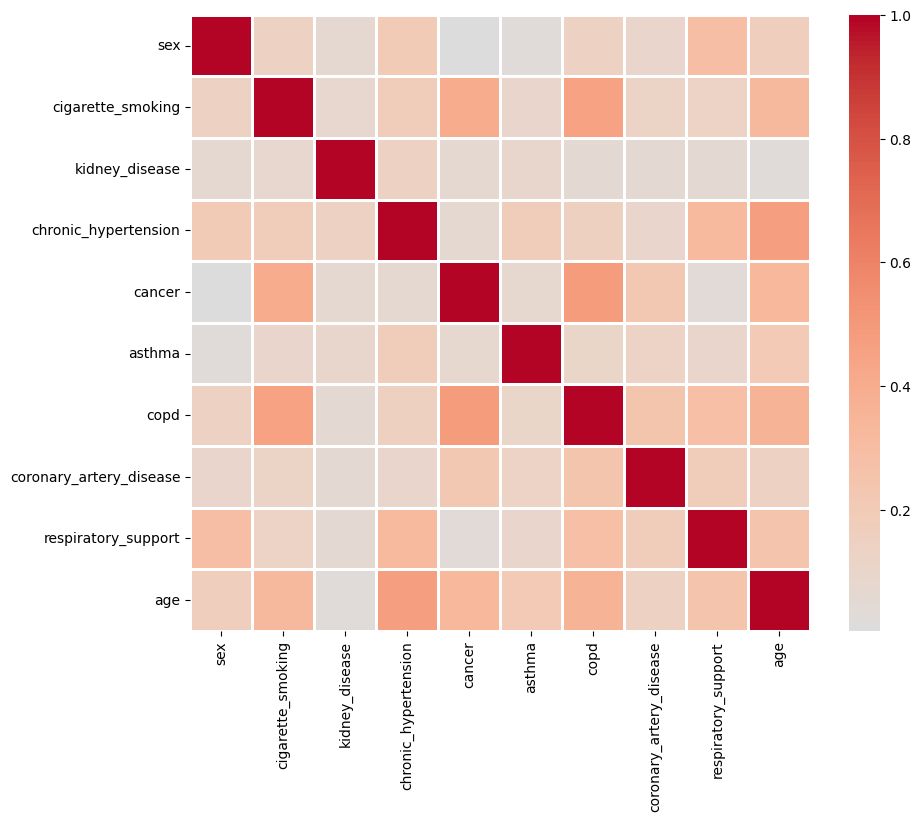

                   Variable       VIF
0                     const  4.914117
1                       sex  1.309138
2         cigarette_smoking  1.322562
3            kidney_disease  2.289139
4      chronic_hypertension  1.456922
5                    cancer  1.493056
6                    asthma  1.322598
7                      copd  2.680319
8   coronary_artery_disease  1.364905
9       respiratory_support  1.339081
10                      age  1.705846
Class distribution before resampling: [37 30 12]
Class distribution after resampling: [37 37 37]
Number of models: 10


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Classification Report for logistic_regression:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        15
           2       1.00      1.00      1.00         6

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40

Validation Classification Report for logistic_regression:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        37
           1       1.00      1.00      1.00        31
           2       1.00      1.00      1.00        11

    accuracy                           1.00        79
   macro avg       1.00      1.00      1.00        79
weighted avg       1.00      1.00      1.00        79

Classification Report for decision_tree:
               precision    recall  f1-score   support

           0       1.00      1.00 

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Classification Report for ada_boost:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        15
           2       1.00      1.00      1.00         6

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40

Validation Classification Report for ada_boost:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        37
           1       1.00      1.00      1.00        31
           2       1.00      1.00      1.00        11

    accuracy                           1.00        79
   macro avg       1.00      1.00      1.00        79
weighted avg       1.00      1.00      1.00        79

Classification Report for xgb:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
          

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:1103: UserWarning: One or more of the test scores are non-finite: [       nan 0.99037698 0.97251984]
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Classification Report for qda:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97        19
           1       1.00      1.00      1.00        15
           2       1.00      0.83      0.91         6

    accuracy                           0.97        40
   macro avg       0.98      0.94      0.96        40
weighted avg       0.98      0.97      0.97        40

Validation Classification Report for qda:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        37
           1       1.00      1.00      1.00        31
           2       1.00      1.00      1.00        11

    accuracy                           1.00        79
   macro avg       1.00      1.00      1.00        79
weighted avg       1.00      1.00      1.00        79

10


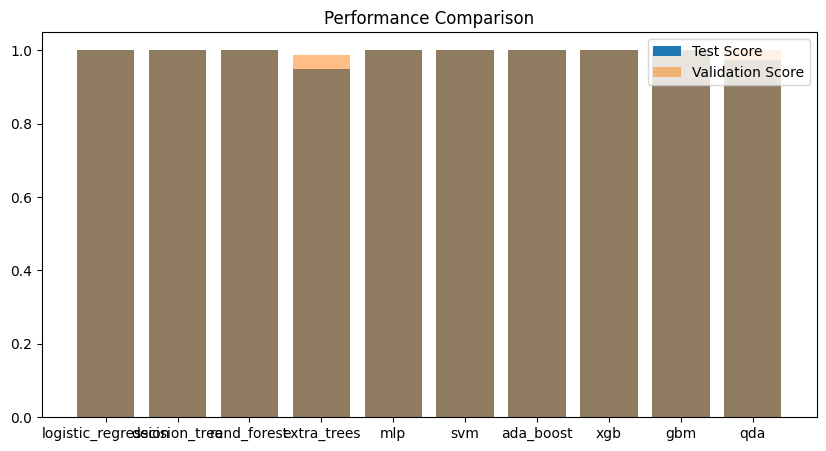

Training set size: (79, 10) (79,)
Testing set size: (40, 10) (40,)
Validation set size: (79, 10) (79,)
Data loaded successfully.
Index(['subject_id', 'Blood Draw', 'Healthy or INCOV', 'age', 'sex', 'BMI',
       'S-1-pyrroline-5-carboxylate', 'spermidine', '1-methylnicotinamide',
       '12,13-DiHOME',
       ...
       'X - 24328', 'X - 24334', 'X - 24337', 'X - 24544', 'X - 24546',
       'X - 24549', 'X - 24556', 'X - 24588', 'X - 24728', 'X - 24812'],
      dtype='object', length=897)
Number of rows with at least one missing value:
ISB Metabolomics:  0
[0 1 2]
X shape: (198, 891)
y shape: (198,)
Size before first split: (198, 891) (198,)
Size after first split - Test set: (40, 891) (40,)
Size before second split: (158, 891) (158,)
Sizes after second split - Train and Val set: (79, 891) (79,) (79, 891) (79,)
Metabolomics Train Target: who_severity
0    0.468354
1    0.379747
2    0.151899
Name: proportion, dtype: float64
Class distribution before resampling: [37 30 12]
Class distrib

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Classification Report for logistic_regression:
               precision    recall  f1-score   support

           0       0.94      0.79      0.86        19
           1       0.80      0.80      0.80        15
           2       0.67      1.00      0.80         6

    accuracy                           0.82        40
   macro avg       0.80      0.86      0.82        40
weighted avg       0.85      0.82      0.83        40

Validation Classification Report for logistic_regression:
               precision    recall  f1-score   support

           0       0.86      0.81      0.83        37
           1       0.76      0.71      0.73        31
           2       0.73      1.00      0.85        11

    accuracy                           0.80        79
   macro avg       0.78      0.84      0.80        79
weighted avg       0.80      0.80      0.80        79

Classification Report for decision_tree:
               precision    recall  f1-score   support

           0       0.65      0.89 

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Classification Report for ada_boost:
               precision    recall  f1-score   support

           0       0.93      0.68      0.79        19
           1       0.59      0.87      0.70        15
           2       0.75      0.50      0.60         6

    accuracy                           0.72        40
   macro avg       0.76      0.68      0.70        40
weighted avg       0.78      0.72      0.73        40

Validation Classification Report for ada_boost:
               precision    recall  f1-score   support

           0       0.85      0.78      0.82        37
           1       0.66      0.74      0.70        31
           2       0.70      0.64      0.67        11

    accuracy                           0.75        79
   macro avg       0.74      0.72      0.73        79
weighted avg       0.75      0.75      0.75        79

Classification Report for xgb:
               precision    recall  f1-score   support

           0       0.93      0.74      0.82        19
          

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Classification Report for qda:
               precision    recall  f1-score   support

           0       0.93      0.68      0.79        19
           1       0.71      0.80      0.75        15
           2       0.67      1.00      0.80         6

    accuracy                           0.78        40
   macro avg       0.77      0.83      0.78        40
weighted avg       0.81      0.78      0.78        40

Validation Classification Report for qda:
               precision    recall  f1-score   support

           0       0.94      0.78      0.85        37
           1       0.75      0.77      0.76        31
           2       0.69      1.00      0.81        11

    accuracy                           0.81        79
   macro avg       0.79      0.85      0.81        79
weighted avg       0.83      0.81      0.81        79

10


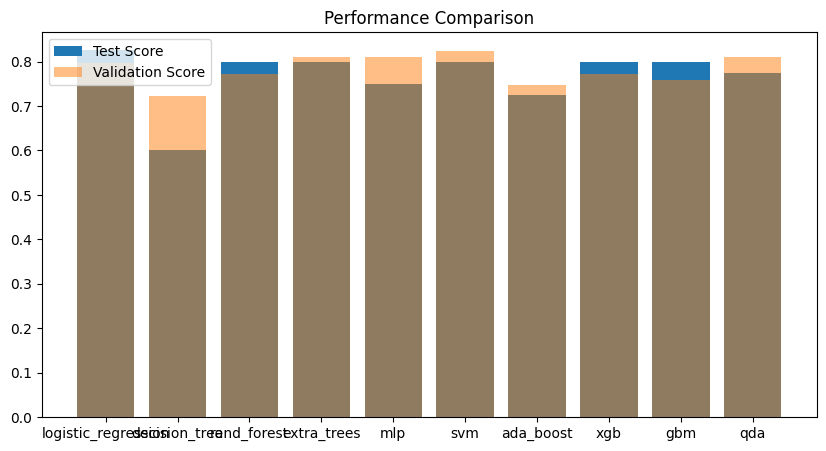

Training set size: (111, 33) (111,)
Testing set size: (40, 33) (40,)
Validation set size: (79, 33) (79,)
Data loaded successfully.
Index(['subject_id', 'Blood Draw', 'Healthy or INCOV', 'age', 'sex', 'BMI',
       'O00182', 'O00220', 'O00253', 'O14763',
       ...
       'Q9UHF1', 'Q9UKL0', 'Q9ULX7', 'Q9UNK0', 'Q9Y478', 'Q9Y4K4', 'Q9Y5A7',
       'Q9Y5L3', 'Q9Y5V3', 'Q9Y653'],
      dtype='object', length=460)
Number of rows with at least one missing value:
ISB Proteomics:  0
[0 1 2]
X shape: (198, 454)
y shape: (198,)
Size before first split: (198, 454) (198,)
Size after first split - Test set: (40, 454) (40,)
Size before second split: (158, 454) (158,)
Sizes after second split - Train and Val set: (79, 454) (79,) (79, 454) (79,)
Proteomics Train Target: who_severity
0    0.468354
1    0.379747
2    0.151899
Name: proportion, dtype: float64
Class distribution before resampling: [37 30 12]
Class distribution after resampling: [37 37 37]
Number of models: 10


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Classification Report for logistic_regression:
               precision    recall  f1-score   support

           0       0.86      0.95      0.90        19
           1       0.77      0.67      0.71        15
           2       0.67      0.67      0.67         6

    accuracy                           0.80        40
   macro avg       0.76      0.76      0.76        40
weighted avg       0.80      0.80      0.80        40

Validation Classification Report for logistic_regression:
               precision    recall  f1-score   support

           0       0.81      0.78      0.79        37
           1       0.56      0.58      0.57        31
           2       0.36      0.36      0.36        11

    accuracy                           0.65        79
   macro avg       0.58      0.58      0.58        79
weighted avg       0.65      0.65      0.65        79

Classification Report for decision_tree:
               precision    recall  f1-score   support

           0       0.84      0.84 

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Classification Report for svm:
               precision    recall  f1-score   support

           0       0.88      0.79      0.83        19
           1       0.67      0.80      0.73        15
           2       0.80      0.67      0.73         6

    accuracy                           0.78        40
   macro avg       0.78      0.75      0.76        40
weighted avg       0.79      0.78      0.78        40

Validation Classification Report for svm:
               precision    recall  f1-score   support

           0       0.83      0.78      0.81        37
           1       0.59      0.61      0.60        31
           2       0.42      0.45      0.43        11

    accuracy                           0.67        79
   macro avg       0.61      0.62      0.61        79
weighted avg       0.68      0.67      0.67        79



/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Classification Report for ada_boost:
               precision    recall  f1-score   support

           0       0.68      0.68      0.68        19
           1       0.53      0.53      0.53        15
           2       0.67      0.67      0.67         6

    accuracy                           0.62        40
   macro avg       0.63      0.63      0.63        40
weighted avg       0.62      0.62      0.62        40

Validation Classification Report for ada_boost:
               precision    recall  f1-score   support

           0       0.68      0.68      0.68        37
           1       0.60      0.58      0.59        31
           2       0.42      0.45      0.43        11

    accuracy                           0.61        79
   macro avg       0.56      0.57      0.57        79
weighted avg       0.61      0.61      0.61        79

Classification Report for xgb:
               precision    recall  f1-score   support

           0       1.00      0.95      0.97        19
          

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Classification Report for gbm:
               precision    recall  f1-score   support

           0       0.85      0.89      0.87        19
           1       0.80      0.80      0.80        15
           2       0.80      0.67      0.73         6

    accuracy                           0.82        40
   macro avg       0.82      0.79      0.80        40
weighted avg       0.82      0.82      0.82        40

Validation Classification Report for gbm:
               precision    recall  f1-score   support

           0       0.73      0.89      0.80        37
           1       0.67      0.52      0.58        31
           2       0.50      0.45      0.48        11

    accuracy                           0.68        79
   macro avg       0.63      0.62      0.62        79
weighted avg       0.67      0.68      0.67        79



/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Classification Report for qda:
               precision    recall  f1-score   support

           0       0.94      0.84      0.89        19
           1       0.69      0.73      0.71        15
           2       0.57      0.67      0.62         6

    accuracy                           0.78        40
   macro avg       0.73      0.75      0.74        40
weighted avg       0.79      0.78      0.78        40

Validation Classification Report for qda:
               precision    recall  f1-score   support

           0       0.88      0.78      0.83        37
           1       0.58      0.61      0.59        31
           2       0.38      0.45      0.42        11

    accuracy                           0.67        79
   macro avg       0.61      0.62      0.61        79
weighted avg       0.69      0.67      0.68        79

10


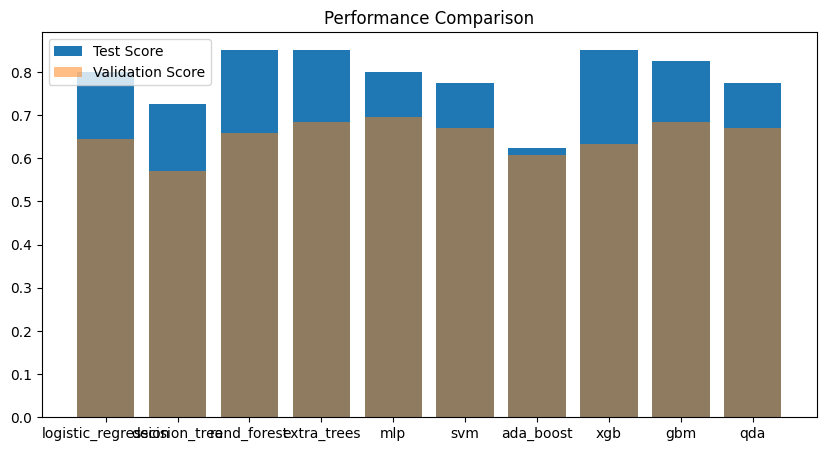

Training set size: (111, 32) (111,)
Testing set size: (40, 32) (40,)
Validation set size: (79, 32) (79,)


(                   0         1         2         3         4         5   \
 subject_id                                                                
 INCOV082    -5.660518  2.016793 -0.482562  1.391652  2.477517  1.723475   
 INCOV076    -5.476593 -0.916454  2.204515 -0.897319  0.033790 -1.142214   
 INCOV176     1.851521  1.768774 -2.582356  0.879693  3.405860  0.544447   
 INCOV161     7.604437  9.777988  0.708535 -2.183111 -0.228104  1.937081   
 INCOV104    -0.668440 -0.248978 -1.313254 -1.105115  2.034167 -0.433303   
 ...               ...       ...       ...       ...       ...       ...   
 INCOV135    -5.221096 -0.566462 -1.999129  0.090016 -0.880354 -1.066363   
 INCOV179     3.059587  0.300361 -0.510682 -4.183986 -0.334645  1.388979   
 INCOV070    10.386168 -3.290548  0.338999  2.679640  1.268594 -2.791912   
 INCOV043    -3.340351  0.187821 -4.809565  0.499961  1.615750  3.300540   
 INCOV057    -4.897066  1.922112  0.064013  1.539890 -1.098110 -0.464114   
 
          

In [ ]:
data_paths = ["/content/drive/MyDrive/Master's Thesis/COVID-19/final-project/final_data/ISB/isb_clinical.xlsx",
              "/content/drive/MyDrive/Master's Thesis/COVID-19/final-project/final_data/ISB/isb_metabolomics.xlsx",
              "/content/drive/MyDrive/Master's Thesis/COVID-19/final-project/final_data/ISB/isb_proteomics.xlsx"
              ]
main(data_paths)

In [ ]:
!zip -r covid_baseline_classifier_outputs.zip covid_baseline_classifier_outputs

  adding: covid_baseline_classifier_outputs/ (stored 0%)
  adding: covid_baseline_classifier_outputs/Proteomics/ (stored 0%)
  adding: covid_baseline_classifier_outputs/Proteomics/X_val.pkl (deflated 7%)
  adding: covid_baseline_classifier_outputs/Proteomics/y_val.pkl (deflated 77%)
  adding: covid_baseline_classifier_outputs/Proteomics/y_train.pkl (deflated 82%)
  adding: covid_baseline_classifier_outputs/Proteomics/X_test.pkl (deflated 8%)
  adding: covid_baseline_classifier_outputs/Proteomics/X_train.pkl (deflated 11%)
  adding: covid_baseline_classifier_outputs/Proteomics/X_proteomics.pkl (deflated 4%)
  adding: covid_baseline_classifier_outputs/Proteomics/y_test.pkl (deflated 70%)
  adding: covid_baseline_classifier_outputs/Metabolomics/ (stored 0%)
  adding: covid_baseline_classifier_outputs/Metabolomics/X_val.pkl (deflated 7%)
  adding: covid_baseline_classifier_outputs/Metabolomics/y_val.pkl (deflated 77%)
  adding: covid_baseline_classifier_outputs/Metabolomics/y_train.pkl (de

In [ ]:
!zip -r vae_outputs.zip vae_outputs

	zip warning: name not matched: vae_outputs

zip error: Nothing to do! (try: zip -r vae_outputs.zip . -i vae_outputs)


## Interpretability on Individual Models

{'xgb__subsample': 1.0, 'xgb__reg_lambda': 0.2, 'xgb__reg_alpha': 0.8, 'xgb__n_estimators': 200, 'xgb__max_depth': 3, 'xgb__learning_rate': 0.25, 'xgb__gamma': 0.2, 'xgb__colsample_bytree': 0.8}

In [10]:
import xgboost as xgb
from sklearn.svm import SVC

In [11]:
proteomics_model = xgb.XGBClassifier(
        subsample = 1.0,
        reg_lambda = 0.2,
        reg_alpha = 0.8,
        n_estimators = 200,
        max_depth = 3,
        learning_rate = 0.25,
        gamma = 0.2,
        colsample_bytree = 0.8
)

metabolomics_model = SVC(
        probability = True,
        max_iter = 700,
        kernel = 'rbf',
        gamma = 'scale',
        class_weight = 'balanced',
        C = 500,
)

clinical_model = RandomForestClassifier(
    n_estimators = 50,
    min_samples_split = 10,
    min_samples_leaf =  2,
    max_depth = 20,
    criterion = 'entropy',
    class_weight = None
)

In [12]:
def load_pre_split_data():
        X_train_pro = joblib.load('/content/drive/MyDrive/covid_baseline_classifier_outputs/Proteomics/X_train.pkl')
        y_train_pro = joblib.load('/content/drive/MyDrive/covid_baseline_classifier_outputs/Proteomics/y_train.pkl')
        X_test_pro = joblib.load('/content/drive/MyDrive/covid_baseline_classifier_outputs/Proteomics/X_test.pkl')
        y_test_pro = joblib.load('/content/drive/MyDrive/covid_baseline_classifier_outputs/Proteomics/y_test.pkl')
        X_val_pro = joblib.load('/content/drive/MyDrive/covid_baseline_classifier_outputs/Proteomics/X_val.pkl')
        y_val_pro = joblib.load('/content/drive/MyDrive/covid_baseline_classifier_outputs/Proteomics/y_val.pkl')

        X_train_met = joblib.load('/content/drive/MyDrive/covid_baseline_classifier_outputs/Metabolomics/X_train.pkl')
        y_train_met = joblib.load('/content/drive/MyDrive/covid_baseline_classifier_outputs/Metabolomics/y_train.pkl')
        X_test_met = joblib.load('/content/drive/MyDrive/covid_baseline_classifier_outputs/Metabolomics/X_test.pkl')
        y_test_met = joblib.load('/content/drive/MyDrive/covid_baseline_classifier_outputs/Metabolomics/y_test.pkl')
        X_val_met = joblib.load('/content/drive/MyDrive/covid_baseline_classifier_outputs/Metabolomics/X_val.pkl')
        y_val_met = joblib.load('/content/drive/MyDrive/covid_baseline_classifier_outputs/Metabolomics/y_val.pkl')

        X_train_clin = joblib.load('/content/drive/MyDrive/covid_baseline_classifier_outputs/Clinical/X_train.pkl')
        y_train_clin = joblib.load('/content/drive/MyDrive/covid_baseline_classifier_outputs/Clinical/y_train.pkl')
        X_test_clin = joblib.load('/content/drive/MyDrive/covid_baseline_classifier_outputs/Clinical/X_test.pkl')
        y_test_clin = joblib.load('/content/drive/MyDrive/covid_baseline_classifier_outputs/Clinical/y_test.pkl')
        X_val_clin = joblib.load('/content/drive/MyDrive/covid_baseline_classifier_outputs/Clinical/X_val.pkl')
        y_val_clin = joblib.load('/content/drive/MyDrive/covid_baseline_classifier_outputs/Clinical/y_val.pkl')

        return X_train_met, y_train_met, X_test_met, y_test_met, X_val_met, y_val_met, X_train_pro, y_train_pro, X_test_pro, y_test_pro, X_val_pro, y_val_pro, X_train_clin, y_train_clin, X_test_clin, y_test_clin, X_val_clin, y_val_clin

In [13]:
def load_model(data_type):
  if data_type == "Proteomics":
      model = proteomics_model

      explainer_type = 'tree'
      shap_filename = 'pro_shap.svg'
      lime_filename = 'pro_lime.html'
      cm_filename = 'pro_confusion_matrix.png'
      output_file_name = 'pro_feature_importance.xlsx'
      index = 10
  elif data_type == "Metabolomics":
      model = metabolomics_model

      explainer_type = 'kernel'
      shap_filename = 'met_shap.svg'
      lime_filename = 'met_lime.html'
      cm_filename = 'met_confusion_matrix.png'
      output_file_name = 'met_feature_importance.xlsx'
      index = 10
  elif data_type == "Clinical":
      model = clinical_model
      loading_matrix = None
      explainer_type = 'tree'
      shap_filename = 'clin_shap.svg'
      lime_filename = 'clin_lime.html'
      cm_filename = 'clin_confusion_matrix.png'
      output_file_name = 'clin_feature_importance.xlsx'
      index = 9
  else:
      raise ValueError(f"Unexpected data_type: {data_type}")
  return model, explainer_type, shap_filename, lime_filename, cm_filename, output_file_name, index

In [14]:
import os
import shap
import numpy as np
import pandas as pd
from lime import lime_tabular
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

def train_and_explain_model(model, X_train, y_train, X_test, y_test, explainer_type, shap_filename, lime_filename, cm_filename, output_dir, output_filename, i):
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    cm = confusion_matrix(y_test, y_pred)

    # Save confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.savefig(cm_filename, dpi=300)
    plt.close()

    # Calculate ROC curve and AUC
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # Handle multi-class ROC for multiclass classification
    if len(np.unique(y_train)) > 2:
        for class_idx in range(y_pred_proba.shape[1]):
            fpr[class_idx], tpr[class_idx], _ = roc_curve(y_test, y_pred_proba[:, class_idx], pos_label=class_idx)
            roc_auc[class_idx] = auc(fpr[class_idx], tpr[class_idx])

            # Plot ROC for each class
            plt.figure()
            plt.plot(fpr[class_idx], tpr[class_idx], color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc[class_idx]:.2f})')
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'Receiver Operating Characteristic - Class {class_idx}')
            plt.legend(loc="lower right")
            roc_filename = f"{output_dir}/roc_curve_class_{class_idx}.png"
            plt.savefig(roc_filename, dpi=300)
            plt.close()
    else:
        # For binary classification
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])
        roc_auc = auc(fpr, tpr)

        # Plot ROC curve
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        roc_filename = f"{output_dir}/roc_curve.png"
        plt.savefig(roc_filename, dpi=300)
        plt.close()

    # SHAP Explainer
    if explainer_type == "tree":
        explainer = shap.TreeExplainer(model)
    elif explainer_type == "kernel":
        explainer = shap.KernelExplainer(model.predict_proba, X_train)
    elif explainer_type == "linear":
        explainer = shap.LinearExplainer(model, X_train)
    else:
        raise ValueError("Invalid explainer type")

    shap_values = explainer.shap_values(X_train)

    # Check if SHAP values are for a multiclass case
    print(f"SHAP values shape: {np.array(shap_values).shape}")  # (samples, features, classes)

    # If it's a multiclass problem (3D array), iterate over classes
    if isinstance(shap_values, list) or len(shap_values.shape) == 3:
        num_classes = shap_values.shape[2] if len(shap_values.shape) == 3 else len(shap_values)
        for class_idx in range(num_classes):
            # Select SHAP values for the current class
            shap_values_for_plot = shap_values[:, :, class_idx]

            # Ensure feature names are passed for the bar plot
            feature_names = list(X_train.columns.values)

            # Generate SHAP summary plot (bar chart) for the current class
            shap.summary_plot(shap_values_for_plot, X_train, feature_names=feature_names, plot_type='bar', show=False)

            # Save the SHAP plot for this class
            class_shap_filename = f"{shap_filename.split('.')[0]}_class_{class_idx}.svg"  # Adjust filename for each class
            plt.savefig(class_shap_filename, dpi=300)
            plt.close()
    else:
        shap_values_for_plot = shap_values

        # Generate SHAP summary plot (bar chart)
        feature_names = list(X_train.columns.values)
        shap.summary_plot(shap_values_for_plot, X_train, feature_names=feature_names, plot_type='bar', show=False)

        # Save SHAP plot
        plt.savefig(shap_filename, dpi=300)
        plt.close()

    # LIME Explainer
    explainer = lime_tabular.LimeTabularExplainer(X_train.to_numpy(),
                                                  feature_names=X_train.columns,
                                                  class_names=["Mild", "Moderate", "Severe"],
                                                  mode='classification',
                                                  random_state=42)
    exp = explainer.explain_instance(X_test.iloc[i].to_numpy(), model.predict_proba, num_features=10)
    exp.save_to_file(os.path.join(os.getcwd(), lime_filename))

    # Print observation details
    observation = X_test.iloc[i]
    observation_df = pd.DataFrame(observation).transpose()
    observation_df['who_severity'] = y_test.iloc[i]
    print(observation_df)

    return y_pred_proba


In [15]:
data_paths = ['baseline_classifier_outputs/Clinical',
              'baseline_classifier_outputs/Metabolomics',
              'baseline_classifier_outputs/Proteomics']

In [16]:
output_dir_met = "output/metabolomics"
output_dir_pro = "output/proteomics"
output_dir_clin = "output/clinical"

In [17]:
from sklearn.multiclass import OneVsRestClassifier

X_train_met, y_train_met, X_test_met, y_test_met, X_val_met, y_val_met, X_train_pro, y_train_pro, X_test_pro, y_test_pro, X_val_pro, y_val_pro, X_train_clin, y_train_clin, X_test_clin, y_test_clin, X_val_clin, y_val_clin = load_pre_split_data()
X_train_met.columns = X_train_met.columns.str.replace('[', '').str.replace(']', '').str.replace('<', '')
X_test_met.columns = X_test_met.columns.str.replace('[', '').str.replace(']', '').str.replace('<', '')
X_train_met.columns = X_train_met.columns.astype(str)
X_test_met.columns = X_test_met.columns.astype(str)

In [ ]:
np.random.seed(42)

met_pred_proba_test = train_and_explain_model(
  metabolomics_model, X_train_met, y_train_met, X_test_met, y_test_met,
  'kernel', 'met_shap.svg', 'met_lime.html', 'met_confusion_matrix.png',
  output_dir_met, 'met_feature_importance.xlsx', 10
)

pro_pred_proba_test = train_and_explain_model(
  proteomics_model, X_train_pro, y_train_pro, X_test_pro, y_test_pro,
  'tree', 'pro_shap.svg', 'pro_lime.html', 'pro_confusion_matrix.png',
  output_dir_pro, 'pro_feature_importance.xlsx', 10
)

clin_pred_proba_test = train_and_explain_model(
  clinical_model, X_train_clin, y_train_clin, X_test_clin, y_test_clin,
  'kernel', 'clin_shap.svg', 'clin_lime.html', 'clin_confusion_matrix.png',
  output_dir_clin, 'clin_feature_importance.xlsx', 10
)

  0%|          | 0/79 [00:00<?, ?it/s]

SHAP values shape: (79, 891, 3)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


          S-1-pyrroline-5-carboxylate  spermidine  1-methylnicotinamide  \
INCOV068                     0.563136    0.257121             -0.698414   

          12,13-DiHOME  alpha-ketoglutarate  kynurenate  3-hydroxyisobutyrate  \
INCOV068      0.746852              0.18766    -0.21625              0.350021   

          3-hydroxy-3-methylglutarate  3-phosphoglycerate   cholate  ...  \
INCOV068                     0.486376            0.968714  0.945676  ...   

          X - 24334  X - 24337  X - 24544  X - 24546  X - 24549  X - 24556  \
INCOV068    0.20665   0.537597  -0.321211  -0.346015   0.169418  -0.562049   

          X - 24588  X - 24728  X - 24812  who_severity  
INCOV068   0.257635   0.302818    7.05683             0  

[1 rows x 892 columns]
SHAP values shape: (79, 454, 3)
            O00182   O00220    O00253    O14763    O14836    O43915    O94907  \
INCOV068  1.634985  0.32666  0.830482  0.597987  1.452608 -0.550641  1.421415   

            P00797    P01127    P01241  .

  0%|          | 0/79 [00:00<?, ?it/s]

SHAP values shape: (79, 10, 3)
          sex  cigarette_smoking  kidney_disease  chronic_hypertension  \
INCOV068  0.0                1.0             0.0                   0.0   

          cancer  asthma  copd  coronary_artery_disease  respiratory_support  \
INCOV068     1.0     0.0   0.0                      0.0                  0.0   

          age  who_severity  
INCOV068  2.0             0  


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [20]:
clin_pred_proba_test = train_and_explain_model(
  clinical_model, X_train_clin, y_train_clin, X_test_clin, y_test_clin,
  'kernel', 'clin_shap.svg', 'clin_lime.html', 'clin_confusion_matrix.png',
  output_dir_clin, 'clin_feature_importance.xlsx', 10
)

  0%|          | 0/79 [00:00<?, ?it/s]

SHAP values shape: (79, 10, 3)
          sex  cigarette_smoking  kidney_disease  chronic_hypertension  \
INCOV068  0.0                1.0             0.0                   0.0   

          cancer  asthma  copd  coronary_artery_disease  respiratory_support  \
INCOV068     1.0     0.0   0.0                      0.0                  0.0   

          age  who_severity  
INCOV068  2.0             0  


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [ ]:
shap_values = np.load("/content/output/metabolomics/met_feature_importance.xlsx_shap_values.npy")

feature_names = X_train_met.columns

print("SHAP values shape:", shap_values.shape)

# loop over all classes (3 classes in this case)
for class_idx in range(shap_values.shape[2]):
    # mean absolute SHAP values for the current class
    class_shap_values = np.abs(shap_values[:, :, class_idx]).mean(axis=0)

    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': class_shap_values
    })

    # sort by importance
    feature_importance = feature_importance.sort_values(by='importance', ascending=False)

    excel_filename = f"met_feature_importance_class_{class_idx}.xlsx"
    feature_importance.to_excel(excel_filename, index=False)

    print(f"Feature Importance for Class {class_idx} saved to {excel_filename}")

FileNotFoundError: [Errno 2] No such file or directory: '/content/output/metabolomics/met_feature_importance.xlsx_shap_values.npy'

In [ ]:
shap_values = np.load("/content/output/proteomics/pro_feature_importance.xlsx_shap_values.npy")

feature_names = X_train_pro.columns

print("SHAP values shape:", shap_values.shape)

# loop over all classes (3 classes in this case)
for class_idx in range(shap_values.shape[2]):
    # mean absolute SHAP values for the current class
    class_shap_values = np.abs(shap_values[:, :, class_idx]).mean(axis=0)

    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': class_shap_values
    })

    # sort by importance
    feature_importance = feature_importance.sort_values(by='importance', ascending=False)

    excel_filename = f"pro_feature_importance_class_{class_idx}.xlsx"
    feature_importance.to_excel(excel_filename, index=False)

    print(f"Feature Importance for Class {class_idx} saved to {excel_filename}")

In [ ]:
shap_values = np.load("/content/output/clinical/clin_feature_importance.xlsx_shap_values.npy")

feature_names = X_train_clin.columns

print("SHAP values shape:", shap_values.shape)

# loop over all classes (3 classes in this case)
for class_idx in range(shap_values.shape[2]):
    # mean absolute SHAP values for the current class
    class_shap_values = np.abs(shap_values[:, :, class_idx]).mean(axis=0)

    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': class_shap_values
    })

    # sort by importance
    feature_importance = feature_importance.sort_values(by='importance', ascending=False)

    excel_filename = f"clin_feature_importance_class_{class_idx}.xlsx"
    feature_importance.to_excel(excel_filename, index=False)

    print(f"Feature Importance for Class {class_idx} saved to {excel_filename}")

In [ ]:
!zip -r output.zip output

updating: output/ (stored 0%)
updating: output/.ipynb_checkpoints/ (stored 0%)
updating: output/proteomics/ (stored 0%)
updating: output/proteomics/roc_curve_class_1.png (deflated 17%)
updating: output/proteomics/roc_curve_class_2.png (deflated 17%)
updating: output/proteomics/roc_curve_class_0.png (deflated 17%)
updating: output/metabolomics/ (stored 0%)
updating: output/metabolomics/roc_curve_class_1.png (deflated 17%)
updating: output/metabolomics/roc_curve_class_2.png (deflated 17%)
updating: output/metabolomics/roc_curve_class_0.png (deflated 17%)
updating: output/clinical/ (stored 0%)
updating: output/clinical/roc_curve_class_1.png (deflated 17%)
updating: output/clinical/roc_curve_class_2.png (deflated 17%)
updating: output/clinical/roc_curve_class_0.png (deflated 17%)


## Stacking

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin

class CustomModel(BaseEstimator, ClassifierMixin):
    def __init__(self, model, feature_indices):
        self.model = model
        self.feature_indices = feature_indices

    def fit(self, X, y=None):
        self.model.fit(X[:, self.feature_indices], y)
        self.classes_ = self.model.classes_  # set the classes_ attribute
        return self

    def predict_proba(self, X):
        return self.model.predict_proba(X[:, self.feature_indices])

    def predict(self, X):
        return self.model.predict(X[:, self.feature_indices])

    def get_params(self, deep=True):
        return {"model": self.model, "feature_indices": self.feature_indices}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)


In [ ]:
X_train = np.concatenate([X_train_met, X_train_pro, X_train_clin], axis=1)
X_test = np.concatenate([X_test_met, X_test_pro, X_test_clin], axis=1)
X_val = np.concatenate([X_val_met, X_val_pro, X_val_clin], axis=1)
y_train = y_train_clin
y_test = y_test_clin
y_val = y_val_clin

# feature indices for each modality (Metabolomics and Proteomics)

metabolomics_feature_indices = list(range(X_train_met.shape[1]))
proteomics_feature_indices = list(range(X_train_met.shape[1], X_train_met.shape[1] + X_train_pro.shape[1]))
clinical_feature_indices = list(range(X_train_met.shape[1] + X_train_pro.shape[1], X_train_met.shape[1] + X_train_pro.shape[1] + X_train_clin.shape[1]))

print("Metabolomics Feature Indices:", metabolomics_feature_indices)
print("Proteomics Feature Indices:", proteomics_feature_indices)
print("Clinical Feature Indices:", clinical_feature_indices)

Metabolomics Feature Indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215,

In [ ]:
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of X_val:", X_val.shape)


Shape of X_train: (118, 1355)
Shape of X_test: (40, 1355)
Shape of X_val: (40, 1355)


In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import cross_val_score
import time
base_models = [
    ('svc', CustomModel(metabolomics_model, metabolomics_feature_indices)),
    ('xgb', CustomModel(proteomics_model, proteomics_feature_indices)),
    ('rf', CustomModel(clinical_model, clinical_feature_indices)),
]

stacked_models = StackingClassifier(estimators=base_models, final_estimator=LogisticRegression(random_state=42, C=0.1))

print(f"Starting model training at: {time.ctime()}")
start_time = time.time()

stacked_models.fit(X_train, y_train)

y_pred = stacked_models.predict(X_test)
y_pred_proba = stacked_models.predict_proba(X_test)
y_pred_val = stacked_models.predict(X_val)
y_pred_proba_val = stacked_models.predict_proba(X_val)

score = accuracy_score(y_test, y_pred)
score_val = accuracy_score(y_val, y_pred_val)
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
roc_auc_val = roc_auc_score(y_val, y_pred_proba_val, multi_class='ovr')
fscore_macro = f1_score(y_test, y_pred, average='macro')
fscore_macro_val = f1_score(y_val, y_pred_val, average='macro')
fscore_weighted = f1_score(y_test, y_pred, average='weighted')
fscore_weighted_val = f1_score(y_val, y_pred_val, average='weighted')
precision = precision_score(y_test, y_pred, average='macro')
precision_val = precision_score(y_val, y_pred_val, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
recall_val = recall_score(y_val, y_pred_val, average='macro')
recall_severe = recall_score(y_test, y_pred, labels=[2], average='macro')
recall_severe_val = recall_score(y_val, y_pred_val, labels=[2], average='macro')


end_time = time.time()
processing_time = end_time - start_time

X_full = np.concatenate([X_train, X_test, X_val], axis=0)
y_full = np.concatenate([y_train, y_test, y_val], axis=0)

cvscore = cross_val_score(stacked_models, X_full, y_full, cv=StratifiedKFold(10), scoring='roc_auc_ovr').mean()

estimators_model = pd.DataFrame()
estimators_model['Models'] = ['Stacking Ensemble Model']
estimators_model['ROC AUC'] = [roc_auc]
estimators_model['ROC AUC Validation'] = [roc_auc_val]
estimators_model['F1-score (macro)'] = [fscore_macro]
estimators_model['F1-score (macro) Validation'] = [fscore_macro_val]
estimators_model['F1-score (weighted)'] = [fscore_weighted]
estimators_model['F1-score (weighted) Validation'] = [fscore_weighted_val]
estimators_model['Precision'] = [precision]
estimators_model['Precision Validation'] = [precision_val]
estimators_model['Recall'] = [recall]
estimators_model['Recall Validation'] = [recall_val]
estimators_model['Recall Severe'] = [recall_severe]
estimators_model['Recall Severe Validation'] = [recall_severe_val]
estimators_model['Score'] = [score]
estimators_model['Score Validation'] = [score_val]
estimators_model['CV Score'] = [cvscore]
estimators_model['Training Time'] = [processing_time]

Starting model training at: Fri Oct  4 17:03:27 2024


In [ ]:
print(estimators_model)

                    Models   ROC AUC  ROC AUC Validation  F1-score (macro)  \
0  Stacking Ensemble Model  0.998366            0.999554          0.914034   

   F1-score (macro) Validation  F1-score (weighted)  \
0                     0.810628             0.945724   

   F1-score (weighted) Validation  Precision  Precision Validation    Recall  \
0                        0.895212     0.9625              0.938596  0.888889   

   Recall Validation  Recall Severe  Recall Severe Validation  Score  \
0           0.787879       0.666667                  0.363636   0.95   

   Score Validation  CV Score  Training Time  
0          0.911392  0.999634       4.370667  


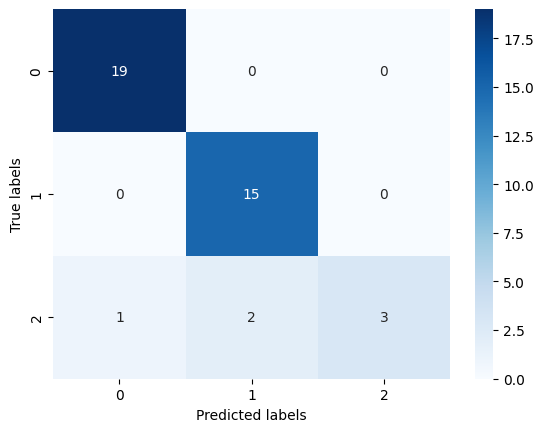

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.savefig('confusion_matrix.png', dpi=300)
plt.show()

In [ ]:
for data_path in data_paths:
    data_type = data_path.split('/')[1]
    print("Data type:", data_type)
    output_dir = os.path.join('covid_baseline_classifier_outputs', data_type)
    X_train, y_train, X_test, y_test, X_val, y_val = load_pre_split_data(data_type)
    model, explainer_type, shap_filename, lime_filename, cm_filename, output_file_name, index = load_model(data_type)
    train_and_explain_model(model, X_train, y_train, X_test, y_test, explainer_type, shap_filename, lime_filename, cm_filename, output_dir, output_file_name, index)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


data = pd.read_excel('/content/met_feature_importance_class_2.xlsx')

data = data.sort_values(by='importance', ascending=True).head(15)

plt.figure(figsize=(8, 6))
plt.scatter(data['importance'], data['feature'], color='purple', s=100)

plt.title('Importance of Plasma Metabolites for Severe Class')
plt.xlabel('Derived Importance Score')
plt.ylabel('Plasma Metabolites')

plt.xlim([0, data['importance'].max() * 1.1])
plt.xticks(rotation=45)

plt.savefig('met_severe_class_importance_plot_top15.png', dpi=300, bbox_inches='tight')

plt.show()